# AWS Amplify

To install:

```zsh
curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"

unzip awscliv2.zip

./aws/install

npm install -y --global @aws-amplify/cli
```

To init amplify project run:

```zsh
amplify init
```

and follow instructions.

To add DynamoDB storage:

```zsh
amplify add storage
```

and follow instructions.

Let's add a AWS Lambda function:

```zsh
amplify add function
```



Change the following file: `code /usercode/react-client-app/amplify/backend/function/LambdaBackendService/src/index.js` with:
```javascript
/**
 * @type {import('@types/aws-lambda').APIGatewayProxyHandler}
 */
// Importing AWS DynamoDB SDK files for JavaScript
const { DynamoDBClient } = require('@aws-sdk/client-dynamodb');
const {
  GetCommand, PutCommand, ScanCommand, UpdateCommand, DeleteCommand, DynamoDBDocumentClient,
} = require('@aws-sdk/lib-dynamodb');

// Client configurations
const config = {
  region: 'us-east-1',
};

// Defining table name set by AWS Amplify
const tableName = 'coursesTable-dev';

// Configuring AWS DynamoDB client
const client = new DynamoDBClient(config);
const documentClient = DynamoDBDocumentClient.from(client);

// The following custom function fetches a specific course in the
// DynamoDB database
async function getItemDB(id) {
  if(!id && id !== 0) { return null; }
  try {
    const command = new GetCommand({
      TableName: tableName,
      Key: {
        ID: Number(id),
      },
    });
    const response = await documentClient.send(command);
    return response;
  } catch (err) {
    console.error(err);
    return null;
  }
}

// The following custom function fetches all course IDs in the
// DynamoDB database
async function getAllItemsDB() {
  try {
    const command = new ScanCommand({
      TableName: tableName,
      ProjectionExpression: 'ID',
    });

    const response = await documentClient.send(command);
    const coursesList = [];
    await Promise.all(response.Items.map(async (item) => {
      const course = await getItemDB(item.ID);
      if (course) { coursesList.push(course.Item); }
    }));
    return coursesList;
  } catch (err) {
    return { error: err.message };
  }
}

// The following custom function adds a new course in the
// DynamoDB database
async function putItemDB(courseObject) {
  try {
    const command = new PutCommand({
      TableName: tableName,
      Item: {
        ID: Number(courseObject.id),
        CourseName: courseObject.courseName,
        CoverArt: decodeURIComponent(courseObject.courseCoverArt),
        CourseUrl: decodeURIComponent(courseObject.courseUrl),
        Author: courseObject.courseAuthor,
      },
    });

    const response = await documentClient.send(command);
    return response;
  } catch (err) {
    return { error: err.message };
  }
}

// The following custom function updates an existing course in the
// DynamoDB database
async function updateItemDB(courseObject) {
  try {
    const command = new UpdateCommand({
      TableName: tableName,
      Key: {
        ID: Number(courseObject.id),
      },
      UpdateExpression: 'SET CourseName = :name, CourseUrl = :url, CoverArt = :coverart, Author = :author',
      ExpressionAttributeValues: {
        ':name': courseObject.courseName,
        ':coverart': decodeURIComponent(courseObject.courseCoverArt),
        ':url': decodeURIComponent(courseObject.courseUrl),
        ':author': courseObject.courseAuthor,
      },
      ReturnValues: 'ALL_NEW',
    });

    const response = await documentClient.send(command);
    return response;
  } catch (err) {
    return { error: err.message };
  }
}

// The following custom function fetches all course IDs in the
// DynamoDB database
async function deleteItemDB(id) {
  try {
    const command = new DeleteCommand({
      TableName: tableName,
      Key: {
        ID: Number(id),
      },
    });

    const response = await documentClient.send(command);
    return response;
  } catch (err) {
    return { error: err.message };
  }
}

// The following custom function fetches all course IDs in the
// DynamoDB database
async function populateItemsDB(coursesJSON) {
  try {
    const courses = JSON.parse(decodeURIComponent(coursesJSON));
    await Promise.all(courses.map(async (course) => {
      await putItemDB({
        id: course.id,
        courseName: course.courseTitle,
        courseCoverArt: course.imgUrl,
        courseUrl: course.courseUrl,
        courseAuthor: course.courseAuthor,
      });
    }));
    return true;
  } catch (error) {
    return false;
  }
}

exports.handler = async (event) => {
  const responseHeaders = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Headers': '*',
  };

  if (!event.queryStringParameters) {
    return {
      statusCode: 400,
      headers: responseHeaders,
      body: JSON.stringify({
        success: false,
        error: 'Invalid Request: Action not provided',
      }),
    };
  }

  // The following variable stores the value of the query parameters in the request
  const requestData = event.queryStringParameters;

  // The following variable stores the action to be performed
  const requestAction = requestData.action;

  // The following variable stores the course ID if it exists
  // in the event arguments
  const courseId = Number(requestData.id);

  // The following conditions get executed when the Lambda function
  // is invoked
  switch (requestAction) {
    // The case when the request query is to get all courses
    case 'allCourses':
      const allCourses = await getAllItemsDB();

      if (allCourses.error) {
        return {
          statusCode: 400,
          headers: responseHeaders,
          body: JSON.stringify({
            success: false,
            error: `Unable to process request for ${requestAction}: ${allCourses.error}`,
          }),
        };
      }

      // Returning response
      return {
        statusCode: 200,
        headers: responseHeaders,
        body: JSON.stringify({
          success: true,
          action: requestAction,
          allCourses,
        }),
      };

      // The case when the request query is to add a new course
    case 'addCourse':
      const addCourse = await putItemDB(requestData);

      if (addCourse.error) {
        return {
          statusCode: 400,
          headers: responseHeaders,
          body: JSON.stringify({
            success: false,
            error: `Unable to process request for ${requestAction}: ${addCourse.error}`,
          }),
        };
      }

      // Returning response
      return {
        statusCode: 200,
        headers: responseHeaders,
        body: JSON.stringify({
          success: true,
          action: requestAction,
        }),
      };

      // The case when the request query is to edit an existing course
    case 'editCourse':
      const editCourse = await updateItemDB(requestData);

      if (editCourse.error) {
        return {
          statusCode: 400,
          headers: responseHeaders,
          body: JSON.stringify({
            success: false,
            error: `Unable to process request for ${requestAction}: ${editCourse.error}`,
          }),
        };
      }

      // Returning response
      return {
        statusCode: 200,
        headers: responseHeaders,
        body: JSON.stringify({
          success: true,
          action: requestAction,
        }),
      };

      // The case when the request query is to edit an existing course
    case 'removeCourse':
      const removeCourse = await deleteItemDB(courseId);

      if (removeCourse.error) {
        return {
          statusCode: 400,
          headers: responseHeaders,
          body: JSON.stringify({
            success: false,
            error: `Unable to process request for ${requestAction}: ${removeCourse.error}`,
          }),
        };
      }

      // Returning response
      return {
        statusCode: 200,
        headers: responseHeaders,
        body: JSON.stringify({
          success: true,
          action: requestAction,
        }),
      };

    case 'populateCourses':
      const poulateCourses = await populateItemsDB(requestData.data);

      if (!poulateCourses) {
        return {
          statusCode: 400,
          headers: responseHeaders,
          body: JSON.stringify({
            success: false,
            error: `Unable to process request for ${requestAction}`,
          }),
        };
      }

      // Returning response
      return {
        statusCode: 200,
        headers: responseHeaders,
        body: JSON.stringify({
          success: true,
          action: requestAction,
        }),
      };

      // The default case when the field itself is unidentified
    default:
      return {
        statusCode: 400,
        headers: responseHeaders,
        body: JSON.stringify({
          success: false,
          error: `Invalid Request: Action ${requestAction} ${typeof requestAction} not found`,
        }),
      };
  }
};
```

```zsh
{
    "AWSTemplateFormatVersion": "2010-09-09",
    "Description": "Custom Lambda function template for AWS Amplify",
    "Parameters": {
        "CloudWatchRule": {
            "Type": "String",
            "Default": "NONE",
            "Description": " Schedule Expression"
        },
        "deploymentBucketName": {
            "Type": "String"
        },
        "env": {
            "Type": "String"
        },
        "s3Key": {
            "Type": "String"
        },
        "storagecoursesTableName": {
            "Type": "String",
            "Default": "storagecoursesTableName"
        },
        "storagecoursesTableArn": {
            "Type": "String",
            "Default": "storagecoursesTableArn"
        }
    },
    "Conditions": {
        "ShouldNotCreateEnvResources": {
            "Fn::Equals": [
                {
                    "Ref": "env"
                },
                "NONE"
            ]
        }
    },
    "Resources": {
        "LambdaFunction": {
            "Type": "AWS::Lambda::Function",
            "Metadata": {
                "aws:asset:path": "./src",
                "aws:asset:property": "Code"
            },
            "Properties": {
                "Code": {
                    "S3Bucket": {
                        "Ref": "deploymentBucketName"
                    },
                    "S3Key": {
                        "Ref": "s3Key"
                    }
                },
                "Handler": "index.handler",
                "FunctionName": {
                    "Fn::If": [
                        "ShouldNotCreateEnvResources",
                        "LambdaBackendService",
                        {
                            "Fn::Join": [
                                "",
                                [
                                    "LambdaBackendService",
                                    "-",
                                    {
                                        "Ref": "env"
                                    }
                                ]
                            ]
                        }
                    ]
                },
                "Environment": {
                    "Variables": {
                        "ENV": {
                            "Ref": "env"
                        },
                        "REGION": {
                            "Ref": "AWS::Region"
                        }
                    }
                },
                "Role": {
                    "Fn::Sub": "arn:aws:iam::${AWS::AccountId}:role/LambdaRole"
                },
                "Runtime": "nodejs18.x",
                "Layers": [],
                "Timeout": 25
            }
        },
        "LambdaExecutionRole": {
            "Type": "AWS::IAM::Role",
            "Properties": {
                "RoleName": "LambdaExecutionRole",
                "AssumeRolePolicyDocument": {
                    "Version": "2012-10-17",
                    "Statement": [
                        {
                            "Effect": "Allow",
                            "Principal": {
                                "Service": [
                                    "lambda.amazonaws.com"
                                ]
                            },
                            "Action": [
                                "sts:AssumeRole"
                            ]
                        }
                    ]
                }
            }
        }
    },
    "Outputs": {
        "Name": {
            "Value": {
                "Ref": "LambdaFunction"
            }
        },
        "Arn": {
            "Value": {
                "Fn::GetAtt": [
                    "LambdaFunction",
                    "Arn"
                ]
            }
        },
        "Region": {
            "Value": {
                "Ref": "AWS::Region"
            }
        },
        "LambdaExecutionRoleArn": {
            "Value": {
                "Fn::GetAtt": [
                    "LambdaExecutionRole",
                    "Arn"
                ]
            }
        }
    }
}
```

"In the Lambda function above, we’ve essentially defined all operations for our course dashboard application. We’ve used the AWS SDK for JavaScript (aws-sdk) to interact with the DynamoDB table to add a new course to the list, edit or delete a specific course in the list, or retrieve the complete course list. We’ll pass any attributes of the course as query parameters in the request to the Lambda function. One additional query parameter that we’ll pass will be the action parameter that defines what type of operation we want to perform."


Next we will edit `code /usercode/react-client-app/amplify/backend/function/LambdaBackendService/LambdaBackendService-cloudformation-template.json`:

```zsh
{
    "AWSTemplateFormatVersion": "2010-09-09",
    "Description": "Custom Lambda function template for AWS Amplify",
    "Parameters": {
        "CloudWatchRule": {
            "Type": "String",
            "Default": "NONE",
            "Description": " Schedule Expression"
        },
        "deploymentBucketName": {
            "Type": "String"
        },
        "env": {
            "Type": "String"
        },
        "s3Key": {
            "Type": "String"
        },
        "storagecoursesTableName": {
            "Type": "String",
            "Default": "storagecoursesTableName"
        },
        "storagecoursesTableArn": {
            "Type": "String",
            "Default": "storagecoursesTableArn"
        }
    },
    "Conditions": {
        "ShouldNotCreateEnvResources": {
            "Fn::Equals": [
                {
                    "Ref": "env"
                },
                "NONE"
            ]
        }
    },
    "Resources": {
        "LambdaFunction": {
            "Type": "AWS::Lambda::Function",
            "Metadata": {
                "aws:asset:path": "./src",
                "aws:asset:property": "Code"
            },
            "Properties": {
                "Code": {
                    "S3Bucket": {
                        "Ref": "deploymentBucketName"
                    },
                    "S3Key": {
                        "Ref": "s3Key"
                    }
                },
                "Handler": "index.handler",
                "FunctionName": {
                    "Fn::If": [
                        "ShouldNotCreateEnvResources",
                        "LambdaBackendService",
                        {
                            "Fn::Join": [
                                "",
                                [
                                    "LambdaBackendService",
                                    "-",
                                    {
                                        "Ref": "env"
                                    }
                                ]
                            ]
                        }
                    ]
                },
                "Environment": {
                    "Variables": {
                        "ENV": {
                            "Ref": "env"
                        },
                        "REGION": {
                            "Ref": "AWS::Region"
                        }
                    }
                },
                "Role": {
                    "Fn::Sub": "arn:aws:iam::${AWS::AccountId}:role/LambdaRole"
                },
                "Runtime": "nodejs18.x",
                "Layers": [],
                "Timeout": 25
            }
        },
        "LambdaExecutionRole": {
            "Type": "AWS::IAM::Role",
            "Properties": {
                "RoleName": "LambdaExecutionRole",
                "AssumeRolePolicyDocument": {
                    "Version": "2012-10-17",
                    "Statement": [
                        {
                            "Effect": "Allow",
                            "Principal": {
                                "Service": [
                                    "lambda.amazonaws.com"
                                ]
                            },
                            "Action": [
                                "sts:AssumeRole"
                            ]
                        }
                    ]
                }
            }
        }
    },
    "Outputs": {
        "Name": {
            "Value": {
                "Ref": "LambdaFunction"
            }
        },
        "Arn": {
            "Value": {
                "Fn::GetAtt": [
                    "LambdaFunction",
                    "Arn"
                ]
            }
        },
        "Region": {
            "Value": {
                "Ref": "AWS::Region"
            }
        },
        "LambdaExecutionRoleArn": {
            "Value": {
                "Fn::GetAtt": [
                    "LambdaExecutionRole",
                    "Arn"
                ]
            }
        }
    }
}
```

We need to perform this action to attach the LambdaRole IAM role we’ve already created for this Lambda function because we don’t provide any permissions to create or modify policies, which the default template requires.


```zsh
amplify build
```

```zsh
amplify status
```



In AWS Amplify, an api refers to a back-end API, which can either be a GraphQL or REST API. We need a back-end API to create and manage our client applications. In this lab, we’ll model this back-end API as a REST API, which can easily be managed through the AWS API Gateway service. API Gateway is an AWS service where we can create, manage, and deploy different APIs on the AWS Cloud.

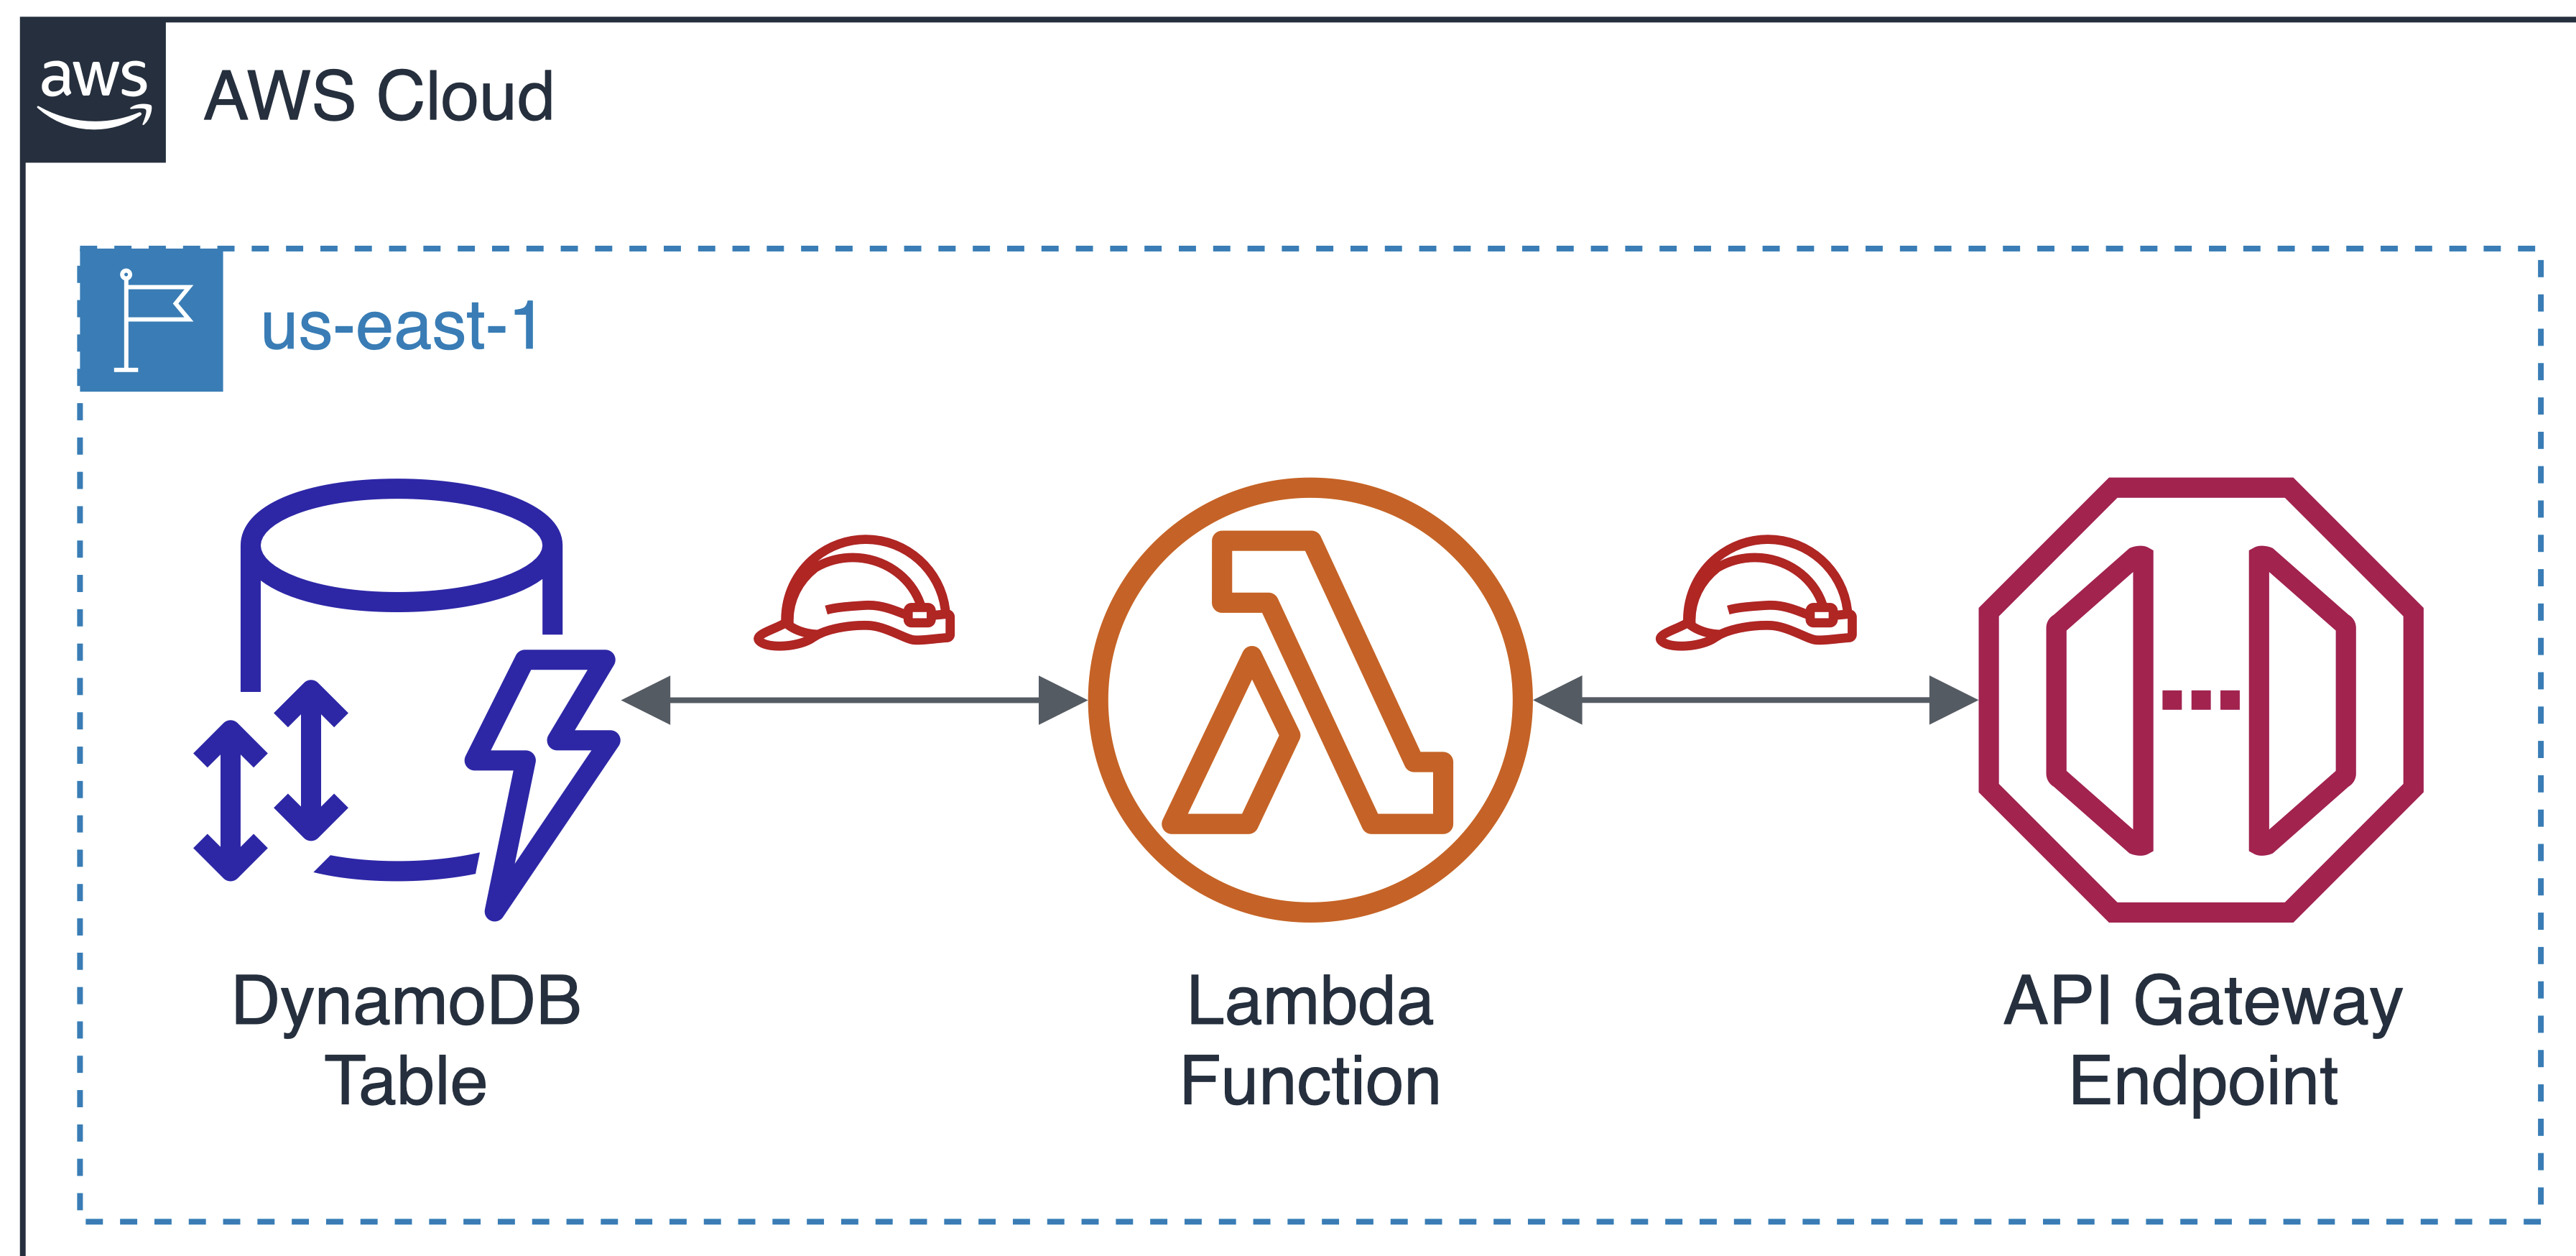

```zsh
amplify add api
```



In this task, we’ll finally deploy all our local back-end resources created using AWS Amplify to the AWS Cloud. Amplify utilizes the AWS CloudFormation service to perform this deployment to create these resources. The CloudFormation service allows developers to use stacks to maintain their project infrastructure according to their requirements. Developers can define AWS resources for their stacks using a CloudFormation template and don’t have to individually create each resource.

```zsh
amplify push
```

```zsh
```

```zsh
```

```zsh
```

```zsh
```

